+----+--------+-----------+-------+-------+----------------+
|    | Course |    Day    | Time  | Room  |  Invigilator   |
+----+--------+-----------+-------+-------+----------------+
| 0  | CS217  |  Tuesday  | 09:00 | C307  | Muhammad Asim  |
| 1  | EE227  |  Monday   | 09:00 | C303  |  Naveed Ahmad  |
| 2  | CS211  | Thursday  | 11:00 | C304  |   Sajid Khan   |
| 3  | SE110  | Wednesday | 09:00 | C302  |  Usman Ashraf  |
| 4  | CS118  | Thursday  | 13:00 | C301  | Hassan Mustafa |
| 5  | CS219  |  Tuesday  | 13:00 | C306  |  Ayesha Bano   |
| 6  | CS220  | Thursday  | 15:00 | C306  | Kifayat Ullah  |
| 7  | CS302  | Thursday  | 13:00 | C309  | Kifayat Ullah  |
| 8  | CY2012 |  Friday   | 13:00 | C309  | Hassan Mustafa |
| 9  | CS307  |  Friday   | 09:00 | C3010 | Ameen Chilwan  |
| 10 | CS328  | Wednesday | 15:00 | C306  |  Shams Farooq  |
| 11 | EE229  |  Friday   | 11:00 | C304  |  Sadia Nauman  |
| 12 | AI2011 |  Tuesday  | 13:00 | C302  | Mehwish Hassan |
| 13 | DS3011 | Thursday

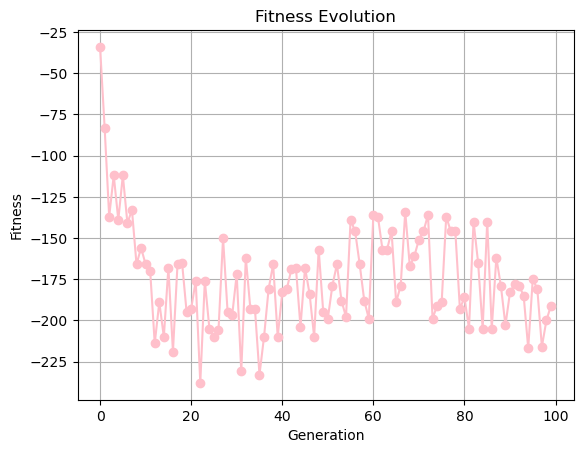

In [4]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict, Counter
from tabulate import tabulate
import matplotlib.pyplot as plt

# Load data
students_df = pd.read_csv("studentNames.csv")
student_courses_df = pd.read_csv("studentCourse.csv")
courses_df = pd.read_csv("courses.csv")
teachers_df = pd.read_csv("teachers.csv")

# Rename columns to standard names
student_courses_df.rename(columns={
    'Course Code': 'CourseCode',
    'Student Name': 'RegNo'
}, inplace=True)

courses_df.rename(columns={'Course Code': 'CourseCode'}, inplace=True)
teachers_df = teachers_df[['Names', 'TeacherID']].rename(columns={'Names': 'Name'})
teachers_df['TeacherID'] = teachers_df['TeacherID'].astype(str)

# Constants
DAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
TIMES = ["09:00", "11:00", "13:00", "15:00"]
CLASSROOMS = [f"C30{i}" for i in range(1, 11)]
POP_SIZE = 50
GENERATIONS = 100
MUTATION_RATE = 0.1

# Mappings
course_students = defaultdict(list)
for _, row in student_courses_df.iterrows():
    course_students[row['CourseCode']].append(row['RegNo'])

teacher_ids = teachers_df['TeacherID'].tolist()
assigned_teachers = random.choices(teacher_ids, k=len(courses_df))
courses_df['TeacherID'] = assigned_teachers

course_teacher = dict(zip(courses_df['CourseCode'], courses_df['TeacherID']))
teacher_names = dict(zip(teachers_df['TeacherID'], teachers_df['Name']))

def generate_random_schedule():
    return [(course, random.choice(DAYS), random.choice(TIMES), random.choice(CLASSROOMS), course_teacher[course])
            for course in courses_df['CourseCode']]

def is_back_to_back(t1, t2):
    order = {"09:00": 0, "11:00": 1, "13:00": 2, "15:00": 3}
    return abs(order[t1] - order[t2]) == 1

def fitness(schedule):
    penalty = 0
    reward = 0
    student_slots = defaultdict(list)
    teacher_slots = defaultdict(list)
    room_usage = defaultdict(list)

    for course, day, time, room, teacher in schedule:
        for student in course_students[course]:
            student_slots[student].append((day, time))
        teacher_slots[teacher].append((day, time))
        room_usage[(day, time, room)].append(course)

        if day == "Friday" and time == "13:00":
            penalty += 5

    for slot, courses in room_usage.items():
        if len(courses) > 1:
            penalty += 10 * (len(courses) - 1)

    for slots in student_slots.values():
        seen = set()
        for d, t in slots:
            if (d, t) in seen:
                penalty += 10
            seen.add((d, t))
        for i in range(len(slots)):
            for j in range(i + 1, len(slots)):
                if slots[i][0] == slots[j][0] and is_back_to_back(slots[i][1], slots[j][1]):
                    reward -= 1

    for slots in teacher_slots.values():
        seen = set()
        for d, t in slots:
            if (d, t) in seen:
                penalty += 10
            seen.add((d, t))

    day_load = defaultdict(lambda: defaultdict(int))
    for teacher, slots in teacher_slots.items():
        for d, _ in slots:
            day_load[teacher][d] += 1
        for count in day_load[teacher].values():
            if count > 1:
                reward -= 1

    # MG before CS
    for student, slots in student_slots.items():
        mg, cs = None, None
        for course in course_students:
            if student in course_students[course]:
                for exam in schedule:
                    if exam[0] == course:
                        idx = (DAYS.index(exam[1]), TIMES.index(exam[2]))
                        if course.startswith("MG"):
                            mg = idx
                        if course.startswith("CS"):
                            cs = idx
        if mg and cs and mg > cs:
            penalty += 3

    # Faculty meeting slots
    slot_teachers = defaultdict(list)
    for teacher, slots in teacher_slots.items():
        for d, t in slots:
            slot_teachers[(d, t)].append(teacher)
    count = sum(1 for v in slot_teachers.values() if len(v) <= len(teacher_ids)//2)
    if count >= 2:
        reward += 5

    return 100 - penalty + reward

def roulette(pop, fits):
    total = sum(fits)
    if total == 0: return random.choice(pop)
    pick, current = random.uniform(0, total), 0
    for ind, fit in zip(pop, fits):
        current += fit
        if current > pick:
            return ind
    return random.choice(pop)

def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:], p2[:point] + p1[point:]

def mutate(schedule):
    if random.random() < MUTATION_RATE:
        idx = random.randint(0, len(schedule)-1)
        course = schedule[idx][0]
        schedule[idx] = (course, random.choice(DAYS), random.choice(TIMES),
                         random.choice(CLASSROOMS), course_teacher[course])
    return schedule

# Run Genetic Algorithm
population = [generate_random_schedule() for _ in range(POP_SIZE)]
best = None
history = []

for _ in range(GENERATIONS):
    fitnesses = [fitness(ind) for ind in population]
    history.append(max(fitnesses))
    if best is None or max(fitnesses) > fitness(best):
        best = population[np.argmax(fitnesses)]

    new_pop = []
    for _ in range(POP_SIZE // 2):
        p1 = roulette(population, fitnesses)
        p2 = roulette(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        new_pop.extend([mutate(c1), mutate(c2)])
    population = new_pop

# Output Results
df = pd.DataFrame(best, columns=["Course", "Day", "Time", "Room", "TeacherID"])
df["Invigilator"] = df["TeacherID"].map(teacher_names)
print(tabulate(df.drop("TeacherID", axis=1), headers="keys", tablefmt="pretty"))

plt.plot(range(GENERATIONS), history, marker='o', color='pink')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution")
plt.grid(True)
plt.show()

